In [1]:
import pymc3 as pm
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
sns.set(font_scale=1.5)

%matplotlib inline

# Coin flip learn things along the way, what can be observed to get the right answer

1. Build a dataset from a contrived distribution where we will know if I get the right answer
1. Build that in Pymc3 
1. Experiment with different observation combinations to see how to get the right answer. 

Refs:
* https://stackoverflow.com/questions/46454814/how-to-simulate-a-biased-6-sided-dice-using-pymc3


## Example on an unfair 6 sided die

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [probs]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
/home/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


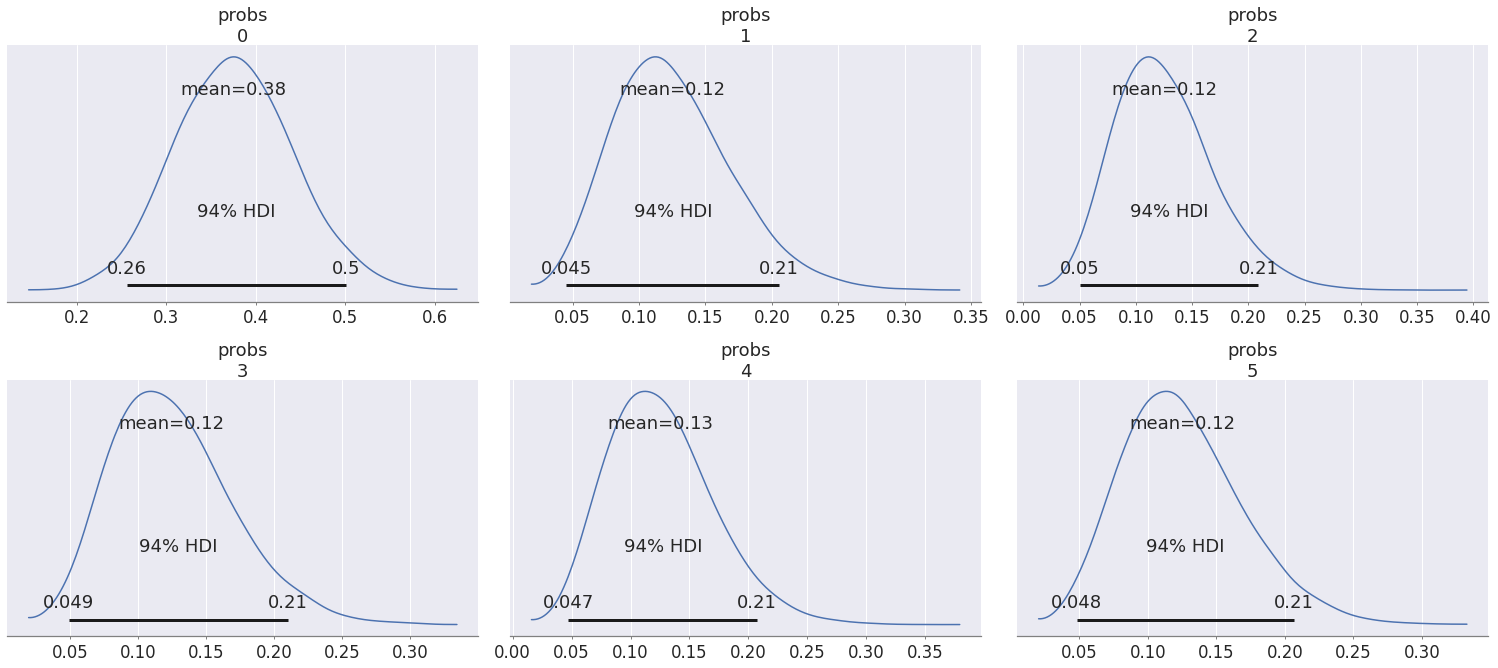

In [2]:
observations = np.array([20, 6, 6, 6, 6, 6])
with pm.Model():
    probs = pm.Dirichlet('probs', a=np.ones(6))  # flat prior
    rolls = pm.Multinomial('rolls', n=50, p=probs, observed=observations)
    trace = pm.sample(5000)
pm.plot_posterior(trace);

/home/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'probs'}>,
        <AxesSubplot:title={'center':'probs'}>]], dtype=object)

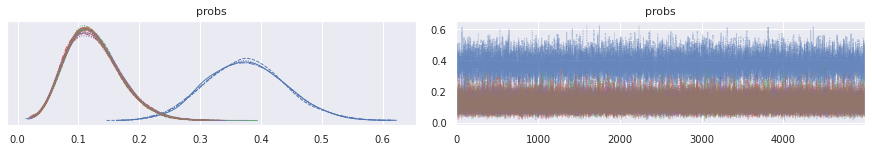

In [3]:
pm.traceplot(trace)


## Now a 4-sided die and pull out hierarchial info

### Get the right answer from the data plain

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [probs]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
/home/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


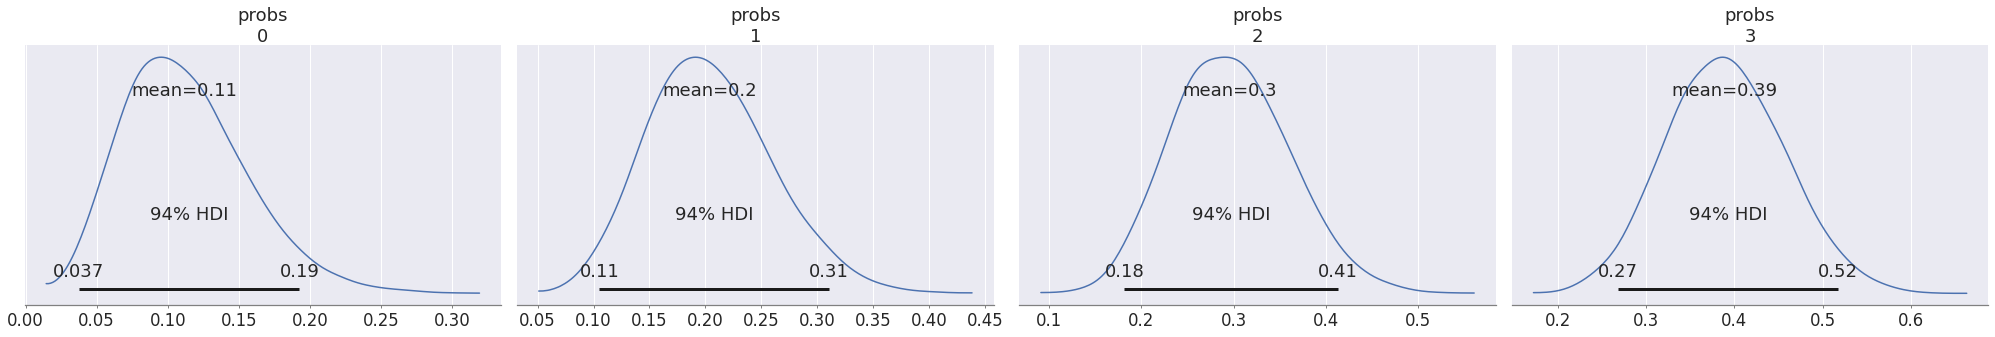

In [4]:
# fair fwould be all the same, we want different
# 1/4 = 0.25, so we want [10%, 20%, 30%, 40%]
observations = np.array([50*.1, 50*.2, 50*.3 ,50*.4])
with pm.Model():
    probs = pm.Dirichlet('probs', a=np.ones(4))  # flat prior
    rolls = pm.Multinomial('rolls', n=observations.sum(), p=probs, observed=observations)
    trace = pm.sample(5000)
# pm.traceplot(trace)
pm.plot_posterior(trace);

## Build the whole thing out the Bernoulli dists

In [5]:
# this is the number of 1,2,3,4
N_rolls = 50
observations = np.array([N_rolls*.1, N_rolls*.2, N_rolls*.3 ,N_rolls*.4])
# so the data for even and odd is, even = 1
obs_evenodd = [1]*observations[np.asarray([1, 3])].sum().astype(int) + [0]*observations[np.asarray([0, 2])].sum().astype(int)
# make then obs_2_4 from even, 2=True
obs_2_4 = [1]*observations[1].astype(int) + [0]*observations[3].astype(int)
# make then obs_1_3 from even, 1=True
obs_1_3 = [1]*observations[0].astype(int) + [0]*observations[2].astype(int)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_1_3, p_2_4, p_evenodd]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.
/home/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


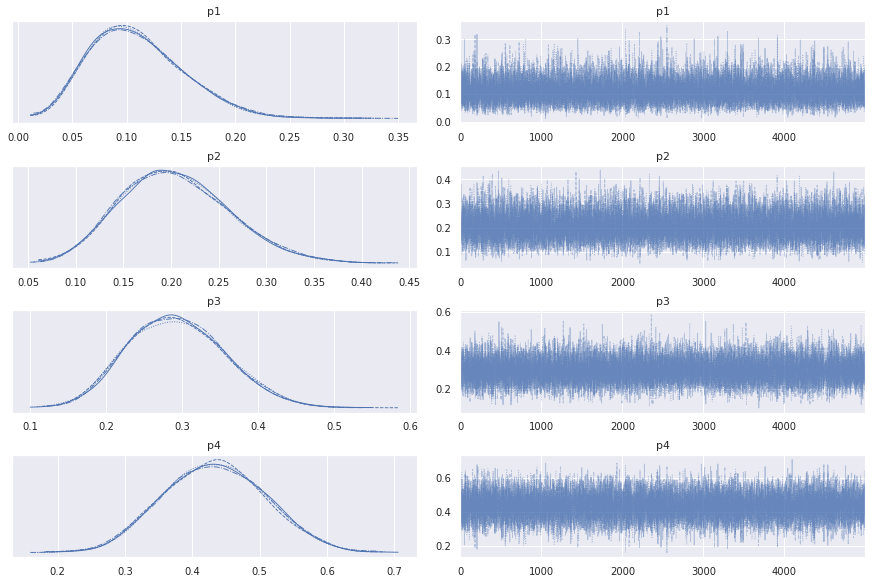

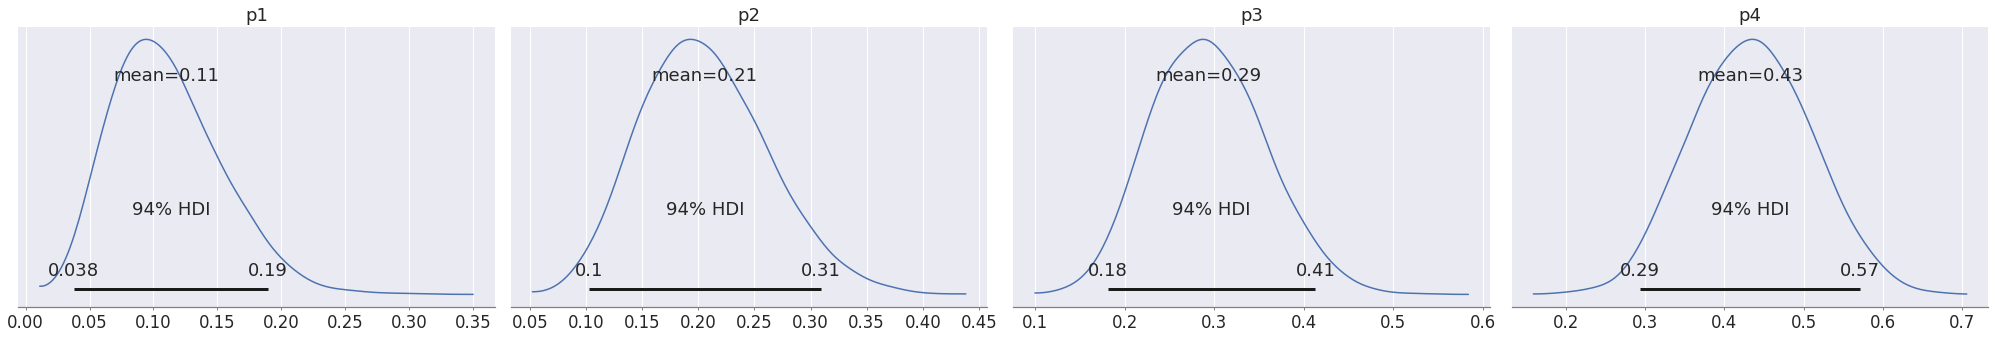

In [6]:

with pm.Model() as our_first_model:
    p_evenodd = pm.Beta('p_evenodd', alpha=1, beta=1)
    evenodd = pm.Bernoulli('evenodd', p=p_evenodd, observed=obs_evenodd)
    
    p_2_4 = pm.Beta('p_2_4', alpha=1, beta=1)
    b_2_4 = pm.Bernoulli('b_2_4', p=p_2_4, observed=obs_2_4)
    
    p_1_3 = pm.Beta('p_1_3', alpha=1, beta=1)
    b_1_3 = pm.Bernoulli('b_1_3', p=p_1_3, observed=obs_1_3)
    
    
    p1 = pm.Deterministic('p1', (1-p_evenodd)*p_1_3)
    p2 = pm.Deterministic('p2', (p_evenodd)*p_2_4)
    p3 = pm.Deterministic('p3', (1-p_evenodd)*(1-p_1_3))
    p4 = pm.Deterministic('p4', (p_evenodd)*(1-p_1_3))
    
    trace = pm.sample(5000,)

pm.traceplot(trace, var_names=['p1', 'p2', 'p3', 'p4'])
pm.plot_posterior(trace, var_names=['p1', 'p2', 'p3', 'p4']);